In [6]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
from itertools import permutations, product
from scipy.stats import norm
from scipy.integrate import odeint
from scipy import signal 

In [10]:
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing

# Initial Values

In [11]:
path = 'Dataset'
Monte = np.load(path + '/Monte.npy')

## Loading Entropies and Create Classes (Chaotic/Stochastic/Determinstic)

In [12]:
Chaotic_entropies = pd.read_csv( path + '/lorenz_entropies.csv')

In [13]:
ARMA_entropies = pd.read_csv( path + '/ARMA_entropies.csv')
WhiteNoise_entropies = pd.read_csv( path + '/WhiteNoise_entropies.csv')
RandomWalk_entropies = pd.read_csv( path + '/RandomWalk_entropies.csv')

Stochastic_entropies = pd.DataFrame()
Stochastic_entropies = ARMA_entropies.append(WhiteNoise_entropies, ignore_index=True)
Stochastic_entropies = Stochastic_entropies.append(RandomWalk_entropies, ignore_index=True)
Stochastic_entropies = Stochastic_entropies.sample(frac=1).reset_index(drop=True) # Shuffling the df
Stochastic_entropies = Stochastic_entropies.iloc[:len(Chaotic_entropies)]

In [14]:
Chirp_entropies = pd.read_csv( path + '/Chirp_entropies.csv')
SineWave_entropies = pd.read_csv( path + '/SineWave_entropies.csv')

Deterministic_entropies = pd.DataFrame()
Deterministic_entropies = Chirp_entropies.append(SineWave_entropies, ignore_index=True)
Deterministic_entropies = Deterministic_entropies.sample(frac=1).reset_index(drop=True) # Shuffling the df
Deterministic_entropies = Deterministic_entropies.iloc[:len(Chaotic_entropies)]

In [15]:
print('length of each class:')
print('Chaotic:',len(Chaotic_entropies))
print('Stochastic:',len(Stochastic_entropies))
print('Deterministic:',len(Deterministic_entropies))

length of each class:
Chaotic: 60
Stochastic: 60
Deterministic: 60


# Entropies: (PeEn)

In [16]:
Entropy_ls = ['PeEn', 'PeEn']

In [17]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [18]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [20]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [21]:
clf_ls = [clf1, clf2, clf3, clf4]

In [22]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       1.00      1.00      1.00        16
           2       1.00      0.88      0.93        16

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [23]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

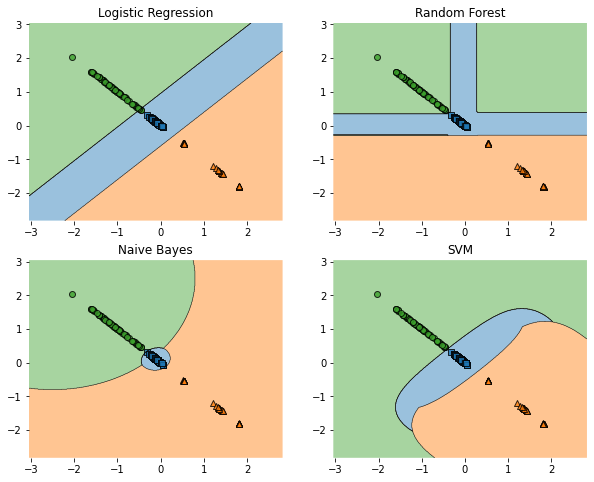

In [24]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (ApEn)

In [25]:
Entropy_ls = ['ApEn', 'ApEn']

In [26]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [27]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [29]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [30]:
clf_ls = [clf1, clf2, clf3, clf4]

In [31]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        18
           1       1.00      0.67      0.80        12
           2       0.70      0.47      0.56        15

    accuracy                           0.73        45
   macro avg       0.79      0.71      0.72        45
weighted avg       0.77      0.73      0.72        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.88      0.78      0.82        18
           1       0.64      0.75      0.69        12
           2       0.67      0.67      0.67        15

    accuracy                           0.73        45
   macro avg       0.73      0.73      0.73        45
weighted avg       0.74      0.73      0.74        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [32]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

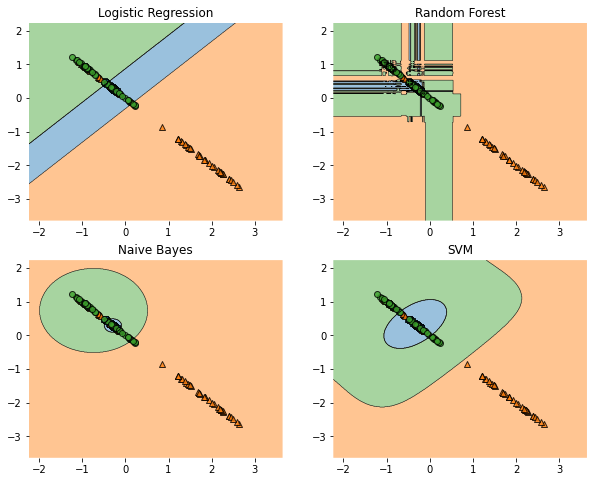

In [33]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (SampEn)

In [34]:
Entropy_ls = ['SampEn', 'SampEn']

In [35]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [36]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [38]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [39]:
clf_ls = [clf1, clf2, clf3, clf4]

In [40]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.58      0.85      0.69        13
           1       1.00      0.65      0.79        17
           2       0.60      0.60      0.60        15

    accuracy                           0.69        45
   macro avg       0.73      0.70      0.69        45
weighted avg       0.75      0.69      0.70        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.79      0.65      0.71        17
           2       0.67      0.67      0.67        15

    accuracy                           0.71        45
   macro avg       0.71      0.72      0.71        45
weighted avg       0.72      0.71      0.71        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [41]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

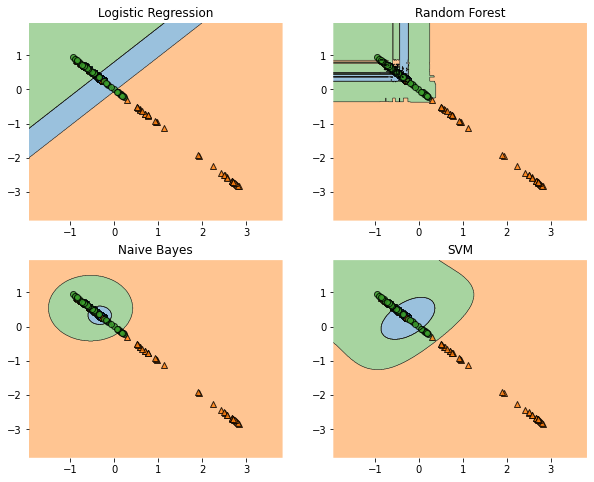

In [42]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (FuzzyEn)

In [43]:
Entropy_ls = ['FuzzyEn', 'FuzzyEn']

In [44]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [45]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [47]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [48]:
clf_ls = [clf1, clf2, clf3, clf4]

In [49]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.72      0.95      0.82        19
           1       0.43      0.46      0.44        13
           2       0.67      0.31      0.42        13

    accuracy                           0.62        45
   macro avg       0.61      0.57      0.56        45
weighted avg       0.62      0.62      0.60        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.76      0.68      0.72        19
           1       0.57      0.62      0.59        13
           2       0.57      0.62      0.59        13

    accuracy                           0.64        45
   macro avg       0.64      0.64      0.64        45
weighted avg       0.65      0.64      0.65        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [50]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

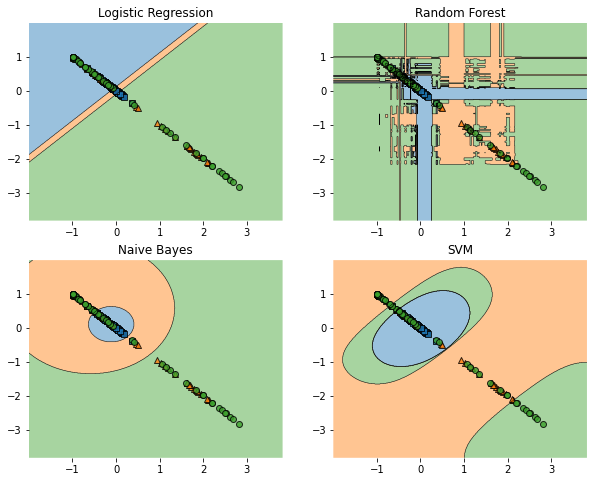

In [51]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (DistEn)

In [52]:
Entropy_ls = ['DistEn', 'DistEn']

In [53]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [54]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [56]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [57]:
clf_ls = [clf1, clf2, clf3, clf4]

In [58]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        16
           1       0.88      0.54      0.67        13
           2       1.00      1.00      1.00        16

    accuracy                           0.84        45
   macro avg       0.86      0.83      0.83        45
weighted avg       0.86      0.84      0.84        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.86      0.75      0.80        16
           1       0.71      0.77      0.74        13
           2       0.94      1.00      0.97        16

    accuracy                           0.84        45
   macro avg       0.84      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [59]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

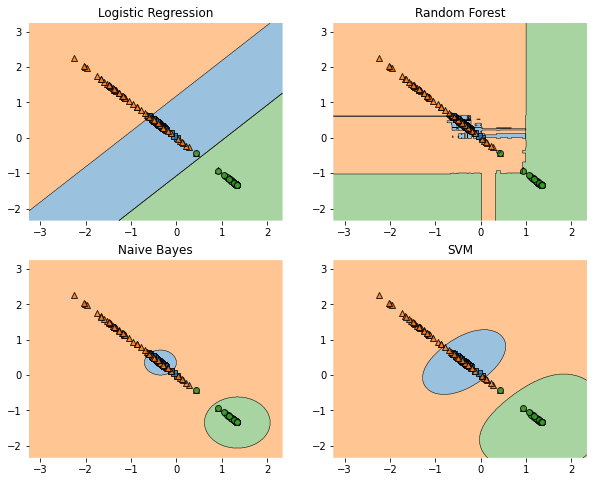

In [60]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (DispEn)

In [62]:
Entropy_ls = ['DispEn', 'DispEn']

In [63]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [64]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [66]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [67]:
clf_ls = [clf1, clf2, clf3, clf4]

In [68]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       1.00      0.58      0.74        12
           2       0.65      0.76      0.70        17

    accuracy                           0.76        45
   macro avg       0.81      0.74      0.75        45
weighted avg       0.79      0.76      0.75        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.71      0.62      0.67        16
           1       0.85      0.92      0.88        12
           2       0.61      0.65      0.63        17

    accuracy                           0.71        45
   macro avg       0.72      0.73      0.73        45
weighted avg       0.71      0.71      0.71        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [69]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

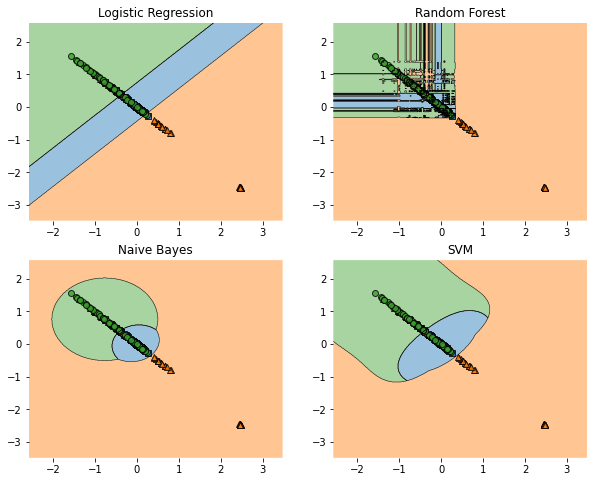

In [70]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (DistEn, DispEn)

In [71]:
Entropy_ls = ['DistEn', 'DispEn']

In [72]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [73]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [75]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [76]:
clf_ls = [clf1, clf2, clf3, clf4]

In [77]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        12
           1       1.00      0.53      0.69        17
           2       1.00      1.00      1.00        16

    accuracy                           0.82        45
   macro avg       0.87      0.84      0.81        45
weighted avg       0.89      0.82      0.82        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.75      1.00      0.86        12
           1       1.00      0.76      0.87        17
           2       1.00      1.00      1.00        16

    accuracy                           0.91        45
   macro avg       0.92      0.92      0.91        45
weighted avg       0.93      0.91      0.91        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [78]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

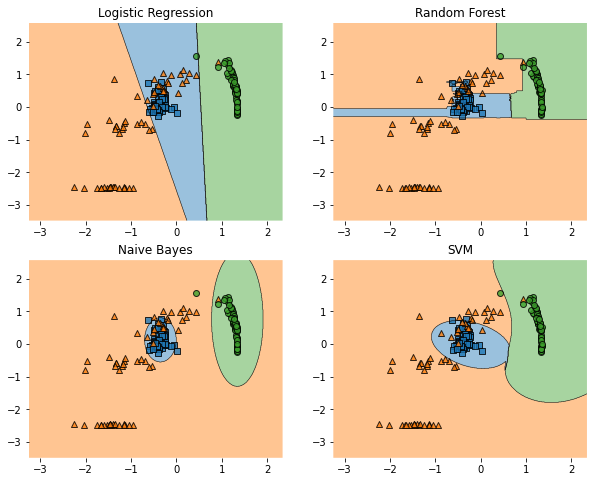

In [79]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (FuzzyEn, PeEn)

In [80]:
Entropy_ls = ['FuzzyEn', 'PeEn']

In [81]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [82]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [84]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [85]:
clf_ls = [clf1, clf2, clf3, clf4]

In [86]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        16

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [87]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

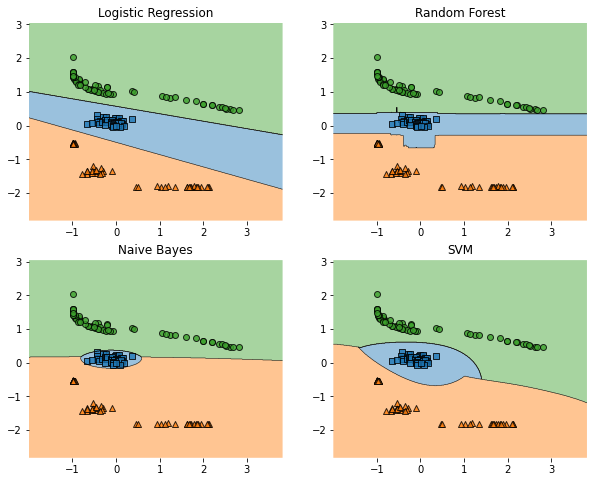

In [88]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (FuzzyEn, DispEn)

In [89]:
Entropy_ls = ['FuzzyEn', 'DispEn']

In [90]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [91]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [93]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [94]:
clf_ls = [clf1, clf2, clf3, clf4]

In [95]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.95      0.95      0.95        20
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      1.00      1.00        20
           2       1.00      0.92      0.96        13

    accuracy                           0.98        45
   macro avg       0.97      0.97      0.97        45
weighted avg       0.98      0.98      0.98        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [96]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

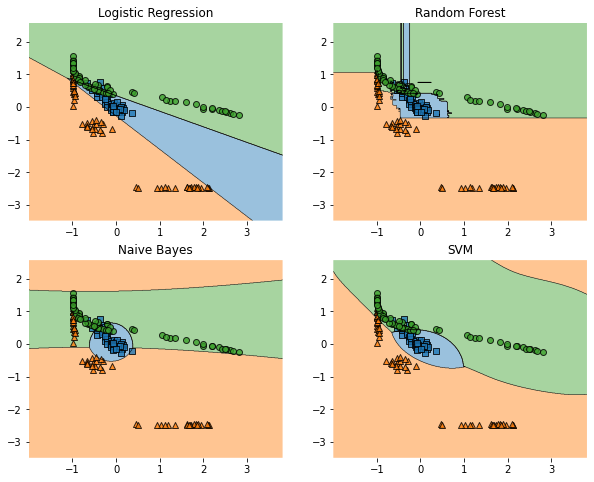

In [97]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()

# Entropies: (ApEn, PeEn)

In [98]:
Entropy_ls = ['ApEn', 'PeEn']

In [99]:
X = np.zeros((3*len(Chaotic_entropies), 3))
X_plot = np.zeros((3*len(Chaotic_entropies),2))
i = 0 ; j = 1 
X_em = Chaotic_entropies[Entropy_ls[i]].to_numpy()
X_em = np.append(X_em, Stochastic_entropies[Entropy_ls[i]].to_numpy())
X_em = np.append(X_em, Deterministic_entropies[Entropy_ls[i]].to_numpy())
X[:,0] = X_em
X_plot[:,0] = X_em

X_self = 1 - Chaotic_entropies[Entropy_ls[j]].to_numpy()
X_self = np.append(X_self, 1 - Stochastic_entropies[Entropy_ls[j]].to_numpy())
X_self = np.append(X_self, 1 - Deterministic_entropies[Entropy_ls[j]].to_numpy())
X[:,1] = X_self
X_plot[:,1] = X_self

X[:,2] = 4 * X_self * X_em 

y = np.zeros(len(Chaotic_entropies), dtype = int)
y = np.append(y, np.ones(len(Chaotic_entropies) , dtype = int))
y = np.append(y, 2*np.ones(len(Chaotic_entropies) , dtype = int))

In [100]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

scaler = preprocessing.StandardScaler().fit(X_plot)
X_plot = scaler.transform(X_plot)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [102]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

In [103]:
clf_ls = [clf1, clf2, clf3, clf4]

In [104]:
for cli in range(len(clf_ls)):
    clf = clf_ls[cli]
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Classifier: {}'.format(clf))
    print(classification_report(y_test, y_pred))

Classifier: LogisticRegression(multi_class='multinomial', random_state=1,
                   solver='newton-cg')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Classifier: RandomForestClassifier(random_state=1)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        14

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Classifier: GaussianNB()
              precision    recall  f1-score   sup

In [105]:
# Training classifiers
clf1 = LogisticRegression(random_state=1,
                          solver='newton-cg',
                          multi_class='multinomial')
clf2 = RandomForestClassifier(random_state=1, n_estimators=100)
clf3 = GaussianNB()
clf4 = SVC(gamma='auto')

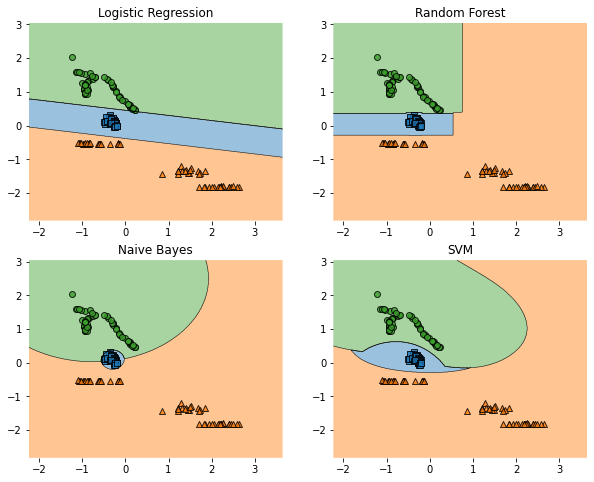

In [106]:
gs = gridspec.GridSpec(2, 2)

fig = plt.figure(figsize=(10,8))

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM']
for clf, lab, grd in zip([clf1, clf2, clf3, clf4],
                         labels,
                         itertools.product([0, 1], repeat=2)):

    clf.fit(X_plot, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_plot, y=y, clf=clf, legend=0)
    plt.title(lab)
plt.show()